## Preprocessing

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
import json
import numpy as np
import os

# Load cleaned CFPB data
df = pd.read_csv("../data/interim/cfpb_mortgage_2024_clean.csv")

# Verify expected columns
print(df.columns)

# Create binary risk flag
RISKY = {"Closed with monetary relief", "Closed with non-monetary relief"}
df["risk_flag"] = df["company_response"].isin(RISKY).astype(int)

# Drop rows with missing or empty narratives
df = df[df["clean_text"].notna() & (df["clean_text"].str.strip() != "")]

# Check class balance
print(df["risk_flag"].value_counts(normalize=True))
print(df["risk_flag"].value_counts())

# First split: train (60%) vs temp (40%)
train_df, temp_df = train_test_split(
    df,
    test_size=0.4,
    stratify=df["risk_flag"],
    random_state=42
)

# Second split: validation (20%) and test (20%) from temp
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df["risk_flag"],
    random_state=42
)

# Confirm split sizes and balance
print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))
print("Train risk ratio:", train_df["risk_flag"].mean())
print("Val risk ratio:", val_df["risk_flag"].mean())
print("Test risk ratio:", test_df["risk_flag"].mean())

# Save splits to data/splits folder
os.makedirs("../data/processed", exist_ok=True)
train_df.to_csv("../data/processed/train.csv", index=False)
val_df.to_csv("../data/processed/val.csv", index=False)
test_df.to_csv("../data/processed/test.csv", index=False)

Index(['complaint_id', 'date_received', 'company', 'issue', 'sub_product',
       'clean_text', 'word_len', 'company_response', 'timely', 'state',
       'month'],
      dtype='object')
risk_flag
0    0.951168
1    0.048832
Name: proportion, dtype: float64
risk_flag
0    11239
1      577
Name: count, dtype: int64
Train: 7089 Val: 2363 Test: 2364
Train risk ratio: 0.048808012413598535
Val risk ratio: 0.048666948793906054
Test risk ratio: 0.049069373942470386


## Baseline Model: TF-IDF

In [25]:
# Import required libraries
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, roc_auc_score, confusion_matrix,
    precision_recall_curve, auc
)
import matplotlib.pyplot as plt
import seaborn as sns

# Load pre-split data
train_df = pd.read_csv("../data/processed/train.csv")
val_df = pd.read_csv("../data/processed/val.csv")
test_df = pd.read_csv("../data/processed/test.csv")

# Extract features and labels
X_train, y_train = train_df["clean_text"], train_df["risk_flag"]
X_val, y_val = val_df["clean_text"], val_df["risk_flag"]
X_test, y_test = test_df["clean_text"], test_df["risk_flag"]

# TF-IDF vectorization
vectorizer = TfidfVectorizer(
    max_features=50000,   # vocabulary cap for efficiency
    ngram_range=(1,1),     # unigrams and bigrams
    stop_words='english',
    min_df=5               # ignore rare tokens
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

# Logistic Regression model with class weighting
model = LogisticRegression(
    class_weight="balanced",
    max_iter=1000,
    solver="liblinear",
    C=0.01,
    random_state=42
)

# Train the model
model.fit(X_train_tfidf, y_train)

# Evaluate generalization between training and validation
y_train_pred = model.predict(X_train_tfidf)
y_train_prob = model.predict_proba(X_train_tfidf)[:, 1]

y_val_pred = model.predict(X_val_tfidf)
y_val_prob = model.predict_proba(X_val_tfidf)[:, 1]

print("Training Results")
print(classification_report(y_train, y_train_pred, digits=3))
print("ROC-AUC:", roc_auc_score(y_train, y_train_prob))

print("\nValidation Results")
print(classification_report(y_val, y_val_pred, digits=3))
print("ROC-AUC:", roc_auc_score(y_val, y_val_prob))


Training Results
              precision    recall  f1-score   support

           0      0.987     0.828     0.901      6743
           1      0.190     0.786     0.306       346

    accuracy                          0.826      7089
   macro avg      0.588     0.807     0.603      7089
weighted avg      0.948     0.826     0.872      7089

ROC-AUC: 0.8902199154936097

Validation Results
              precision    recall  f1-score   support

           0      0.977     0.811     0.886      2248
           1      0.147     0.635     0.238       115

    accuracy                          0.802      2363
   macro avg      0.562     0.723     0.562      2363
weighted avg      0.937     0.802     0.855      2363

ROC-AUC: 0.8033614420547733


Test Results
              precision    recall  f1-score   support

           0      0.973     0.799     0.878      2248
           1      0.129     0.578     0.211       116

    accuracy                          0.788      2364
   macro avg      0.551     0.688     0.544      2364
weighted avg      0.932     0.788     0.845      2364

ROC-AUC: 0.7852228801079887


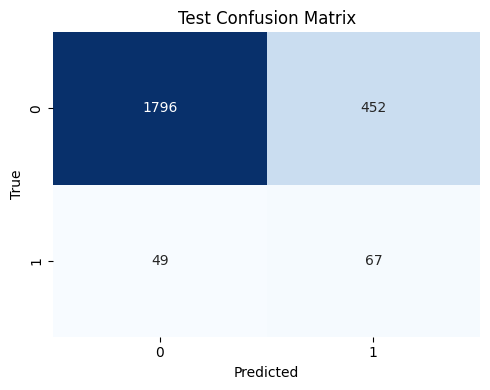

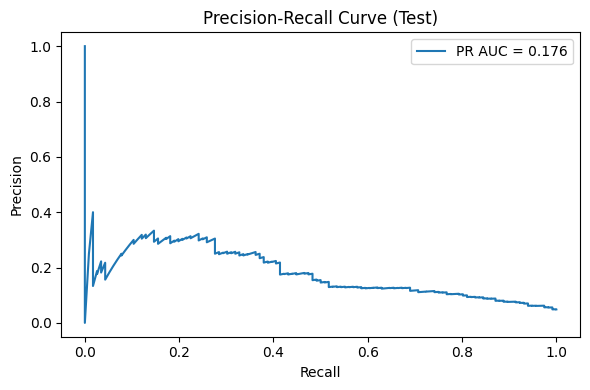

In [26]:
# Predict on test set
test_preds = model.predict(X_test_tfidf)
test_probs = model.predict_proba(X_test_tfidf)[:, 1]

# Print performance report
print("Test Results")
print(classification_report(y_test, test_preds, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, test_probs))

# Confusion matrix
cm_test = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Test Confusion Matrix")
plt.tight_layout()
plt.show()

# Precision-Recall curve
prec, rec, _ = precision_recall_curve(y_test, test_probs)
pr_auc = auc(rec, prec)

plt.figure(figsize=(6, 4))
plt.plot(rec, prec, label=f"PR AUC = {pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Test)")
plt.legend()
plt.tight_layout()
plt.show()



In [ ]:
# Save results for later
baseline_results = {
    "model_name": "tfidf_logreg_baseline",
    "performance": {
        "test": {
            "roc_auc": float(roc_auc_score(y_test, test_probs)),
            "precision_risk": float(np.round(classification_report(y_test, test_preds, output_dict=True)['1']['precision'], 3)),
            "recall_risk": float(np.round(classification_report(y_test, test_preds, output_dict=True)['1']['recall'], 3)),
            "f1_risk": float(np.round(classification_report(y_test, test_preds, output_dict=True)['1']['f1-score'], 3)),
            "accuracy": float(np.round(classification_report(y_test, test_preds, output_dict=True)['accuracy'], 3))
        }
    }
}

# Create output folder
os.makedirs("../outputs/models", exist_ok=True)

# Save as JSON
output_path = "../outputs/models/baseline_tfidf_logreg_results.json"
with open(output_path, "w") as f:
    json.dump(baseline_results, f, indent=4)

## Improved Model: FinBERT & LoRA

### Load FinBERT

In [31]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# Load data
train_df = pd.read_csv("../data/processed/train.csv")
val_df   = pd.read_csv("../data/processed/val.csv")
test_df  = pd.read_csv("../data/processed/test.csv")

# Initiate tokenizer for FinBERT
model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

# Convert DF into a PyTorch dataset
class ComplaintsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = list(texts)
        self.labels = list(labels)
        self.tokenizer = tokenizer
        self.max_length = max_length
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])
        enc = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long)
        }

train_ds = ComplaintsDataset(train_df["clean_text"], train_df["risk_flag"], tokenizer)
val_ds   = ComplaintsDataset(val_df["clean_text"], val_df["risk_flag"], tokenizer)
test_ds  = ComplaintsDataset(test_df["clean_text"], test_df["risk_flag"], tokenizer)

batch_size = 16
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print("train batches:", len(train_loader))
print("val batches:", len(val_loader))
print("test batches:", len(test_loader))

# Loan FinBERT
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2, # Set number of labels to 2 (risk, no risk)
    ignore_mismatched_sizes=True # since we are changing the num of labels
).to(device)

print("FinBERT model loaded successfully")

device: cpu
train batches: 444
val batches: 148
test batches: 148


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FinBERT model loaded successfully


### LoRA Fine-Tuning

### Complaint Early Warning Model

## Validation and Comparison of Baseline and Improved Models